# Mastering Image Classification: Building a Deep Learning Model for Natural Scene Recognition

In [17]:
# Fastai modules
from fastai.vision.all import *
from fastai.metrics import error_rate

# Torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OpenCV for image processing
import cv2

# File and path handling
import os
from pathlib import Path

# KaggleHub integration
import kagglehub

# Evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", dataset_path)


Path to dataset files: /Users/julia/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [4]:
path = Path(dataset_path)
train_path = path / 'seg_train' / 'seg_train'
test_path = path / 'seg_test' / 'seg_test'
pred_path = path / 'seg_pred'


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Data augmentation for the training set
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),              # Random rotation of 15 degrees
    transforms.RandomHorizontalFlip(),          # Random horizontal flip
    transforms.ColorJitter(brightness=0.2,      # Adjust brightness, contrast
                           contrast=0.2, 
                           saturation=0.2),
    transforms.Resize((150, 150)),              # Resize to model's expected size
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to pre-trained model expectations
                         std=[0.229, 0.224, 0.225])
])

# Minimal preprocessing for validation and test sets
test_val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),              # Resize to model's expected size
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to pre-trained model expectations
                         std=[0.229, 0.224, 0.225])
])


In [6]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data = datasets.ImageFolder(root=test_path, transform=val_test_transform)
pred_data = datasets.ImageFolder(root=pred_path, transform=val_test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
pred_loader = DataLoader(pred_data, batch_size=batch_size, shuffle=False)


In [7]:
def denormalize(image):
    image = image * 0.5 + 0.5
    return image

def visualize_augmentations(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        image = images[i]
        label = labels[i]

        image = denormalize(image)

        np_image = image.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

        ax.imshow(np_image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")
    plt.show()


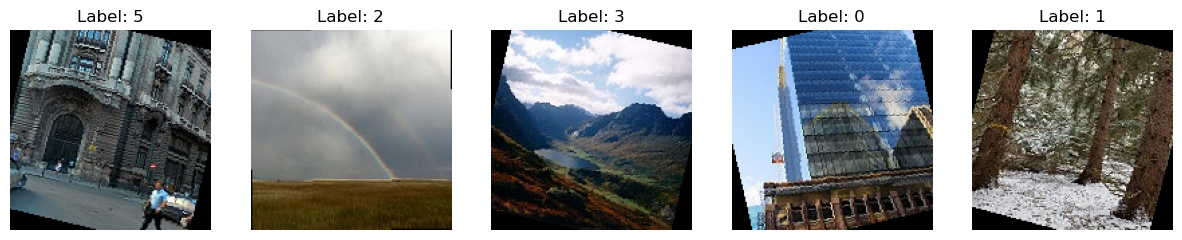

In [8]:
visualize_augmentations(train_loader)


## Building a Simple Convolutional Neural Network (CNN)

In [24]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [10]:
num_classes = len(train_path.ls())
simple_snn = SimpleCNN(num_classes=num_classes)
simple_snn = simple_snn.to(device)


## Transfer Learning with ResNet18 Model Preparing

In [11]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

for param in resnet18.parameters():
    param.requires_grad = False  # Freeze all layers

for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18 = resnet18.to(device)


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_snn = optim.Adam(simple_snn.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.0001)


## Define functions for training of models

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy
    

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path="best_model.pth"):
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Store metrics

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved Best Model at Epoch {epoch+1} with Validation Accuracy: {val_accuracy:.2f}%")

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.2f}%")
    return history

In [15]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Train and Save models


Training SimpleCNN...
Saved Best Model at Epoch 1 with Validation Accuracy: 73.57%
Epoch [1/10]
Train Loss: 0.9550, Train Accuracy: 63.27%
Validation Loss: 0.7240, Validation Accuracy: 73.57%
--------------------------------------------------
Saved Best Model at Epoch 2 with Validation Accuracy: 79.16%
Epoch [2/10]
Train Loss: 0.6389, Train Accuracy: 76.16%
Validation Loss: 0.5901, Validation Accuracy: 79.16%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.5403, Train Accuracy: 80.07%
Validation Loss: 0.5542, Validation Accuracy: 78.84%
--------------------------------------------------
Saved Best Model at Epoch 4 with Validation Accuracy: 80.83%
Epoch [4/10]
Train Loss: 0.4542, Train Accuracy: 83.69%
Validation Loss: 0.5277, Validation Accuracy: 80.83%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.4084, Train Accuracy: 85.32%
Validation Loss: 0.5521, Validation Accuracy: 80.51%
---------------------------------------------

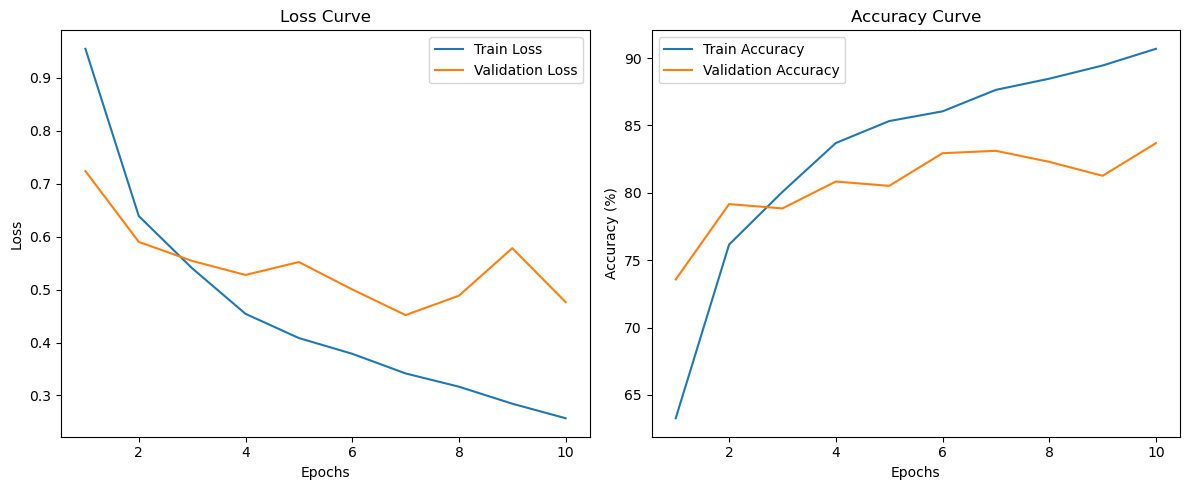


Training ResNet18...
Saved Best Model at Epoch 1 with Validation Accuracy: 72.68%
Epoch [1/10]
Train Loss: 1.4126, Train Accuracy: 49.51%
Validation Loss: 1.0028, Validation Accuracy: 72.68%
--------------------------------------------------
Saved Best Model at Epoch 2 with Validation Accuracy: 81.08%
Epoch [2/10]
Train Loss: 0.8596, Train Accuracy: 77.50%
Validation Loss: 0.7038, Validation Accuracy: 81.08%
--------------------------------------------------
Saved Best Model at Epoch 3 with Validation Accuracy: 82.94%
Epoch [3/10]
Train Loss: 0.6750, Train Accuracy: 81.33%
Validation Loss: 0.6065, Validation Accuracy: 82.94%
--------------------------------------------------
Saved Best Model at Epoch 4 with Validation Accuracy: 83.15%
Epoch [4/10]
Train Loss: 0.5837, Train Accuracy: 82.59%
Validation Loss: 0.5420, Validation Accuracy: 83.15%
--------------------------------------------------
Saved Best Model at Epoch 5 with Validation Accuracy: 83.90%
Epoch [5/10]
Train Loss: 0.5369, 

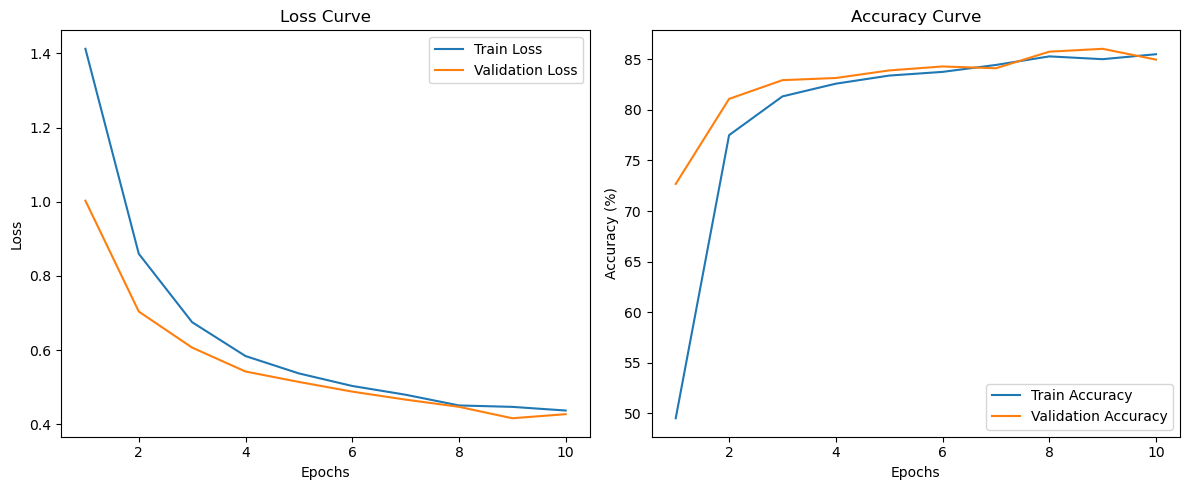

In [16]:
print("\nTraining SimpleCNN...")
history_snn = train_model(simple_snn, train_loader, val_loader, criterion, optimizer_snn, num_epochs=10, device=device, save_path="simple_cnn_best.pth")
plot_metrics(history_snn)

print("\nTraining ResNet18...")
history_resnet = train_model(resnet18, train_loader, val_loader, criterion, optimizer_resnet, num_epochs=10, device=device, save_path="resnet18_best.pth")
plot_metrics(history_resnet)

### load saved models

In [33]:
simple_snn = SimpleCNN(num_classes=6).to(device)
simple_snn.load_state_dict(torch.load("simple_cnn_best.pth", weights_only=True))
simple_snn.eval()

resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 6)
resnet18.load_state_dict(torch.load("resnet18_best.pth", weights_only=True))
resnet18 = resnet18.to(device)
resnet18.eval()

print("Models loaded successfully.")


Models loaded successfully.


In [37]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=next(model.parameters()).dtype)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, report, cm


In [ ]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [39]:
print("\nEvaluating SimpleCNN on Test Dataset...")
accuracy_snn, f1_snn, report_snn, cm_snn = evaluate_model(simple_snn, test_loader, device)
print(f"SimpleCNN Accuracy: {accuracy_snn:.2f}")
print(f"SimpleCNN F1-score: {f1_snn:.2f}")
print("Classification Report:\n", report_snn)

print("\nEvaluating ResNet18 on Test Dataset...")
accuracy_resnet, f1_resnet, report_resnet, resnet_cm = evaluate_model(resnet18, test_loader, device)
print(f"ResNet18 Accuracy: {accuracy_resnet:.2f}")
print(f"ResNet18 F1-score: {f1_resnet:.2f}")
print("Classification Report:\n", report_resnet)



Evaluating SimpleCNN on Test Dataset...
SimpleCNN Accuracy: 0.85
SimpleCNN F1-score: 0.85
Classification Report:
               precision    recall  f1-score   support

   buildings       0.79      0.89      0.83       437
      forest       0.98      0.93      0.95       474
     glacier       0.81      0.77      0.79       553
    mountain       0.77      0.83      0.80       525
         sea       0.87      0.86      0.86       510
      street       0.89      0.82      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000


Evaluating ResNet18 on Test Dataset...
ResNet18 Accuracy: 0.87
ResNet18 F1-score: 0.87
Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.89      0.87       437
      forest       0.96      0.96      0.96       474
     glacier       0.82      0.81      0.82       553
    mountain 

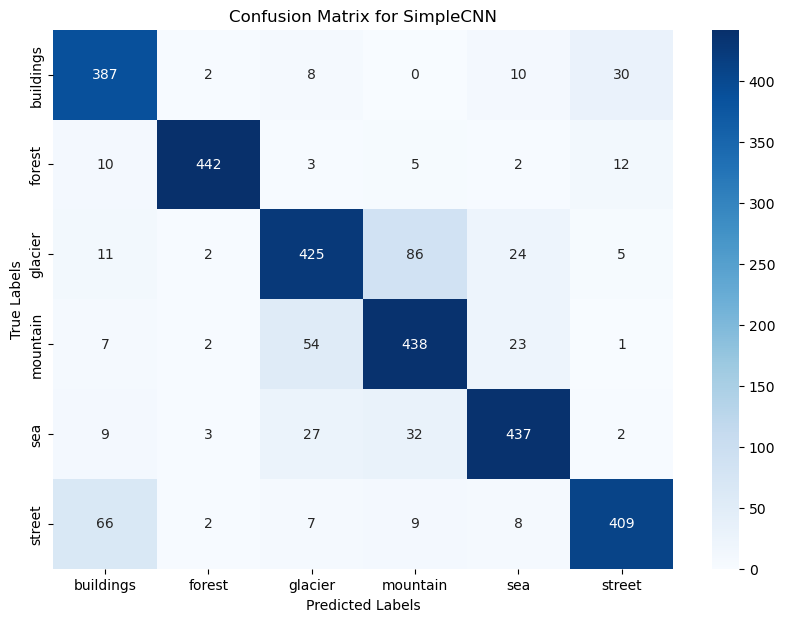

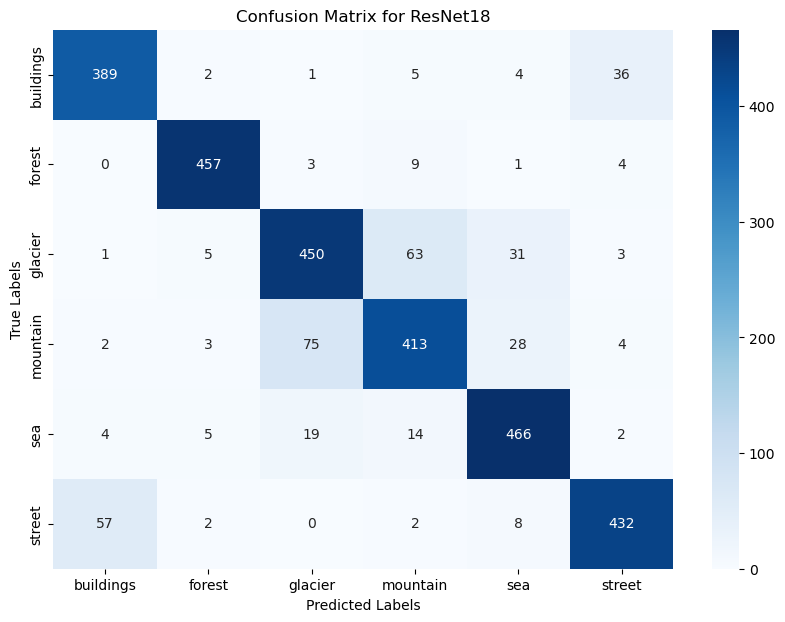

In [40]:
plot_confusion_matrix(cm_snn, test_loader.dataset.classes, "SimpleCNN")

plot_confusion_matrix(resnet_cm, test_loader.dataset.classes, "ResNet18")